# All Classifiers- 1-July-2017
----------------------------
## Summary
1. Hierarchical Clustering 
2. Separability in PCA space
3. Removing running and jumping: ROC Curves for Logistic Regressions
4. Classification: Log Regr, kNN, Random Forest, SVM
----------------------------

#### Imports 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster import hierarchy

from __future__ import division
from datetime import datetime

#### Set up formats

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

sns.set_style('white')
sns.set_context("paper")

#### Helper functions - for handling data

In [3]:
# get data from the data file
def get_data(data_dict, data_id):
    data_name = data_dict.get_value(data_id,'long_name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    data = df.iloc[:,1:]
    target = df.fall
    return data_name, data, target

def remove_running_jumping(data,target,test_dict):

    data_new = data.copy(deep = True)
    target_new = target.copy(deep = True)
    
    data_new = data_new.join(test_dict[['activity']])
    data_new = data_new[(data_new.activity != 'jumping') & (data_new.activity != 'running')]
    data_new = data_new.drop('activity',axis=1)
    
    target_new = pd.DataFrame(target_new)
    target_new = target_new.join(test_dict[['activity']])
    target_new = target_new[(target_new.activity != 'jumping') & (target_new.activity != 'running')]
    target_new = target_new['fall']
    
    return data_new, target_new

#### Helper functions for model scoring 

In [4]:
# calculates accuracy, prob of detection and prob of false alarm
def model_scores(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    TN = cm[0,0]
    FN = cm[1,0]
    TP = cm[1,1]
    FP = cm[0,1]
    accuracy = (TN + TP)/(TN + FP + FN + TP) 
    prob_detect = TP / (TP + FN)
    prob_false_alarm = FP /(TN + FP)
    return accuracy, prob_detect, prob_false_alarm

#calculates  model metrics for training and test sets
def model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='', data_name='', data_kind = '', info=''):
    
    # accuracy, probability of detection, probability of false alarm 
    train_accuracy, train_pod, train_pfa  = model_scores(y_train, clf.predict(X_train))
    test_accuracy, test_pod, test_pfa  = model_scores(y_test, clf.predict(X_test))
    
    # area under the curve    
    fpr, tpr, _ = metrics.roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
    train_auc = metrics.auc(fpr, tpr)
    fpr, tpr, _ = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    test_auc = metrics.auc(fpr, tpr)
    
    # aggregate results
    result = pd.DataFrame({'classifier': clf_name, 'data_set': data_name,'data_kind':data_kind, 'info': info,
        'train_accuracy': train_accuracy,'train_PoD': train_pod,'train_PFA': train_pfa,'train_AUC': train_auc,
        'test_accuracy': test_accuracy, 'test_PoD': test_pod,'test_PFA': test_pfa,'test_AUC': test_auc},index = [0])
    
    columns = ['data_set','data_kind','classifier', 'test_accuracy', 'test_PoD', 'test_PFA', 'test_AUC',
              'train_accuracy', 'train_PoD', 'train_PFA', 'train_AUC', 'info']
    result = result[columns]
    return result

-----------------
### Read in data dictionary for available datasets

In [5]:
data_dict = pd.read_csv('data/data_dict.csv', index_col = 0)
data_dict

,name,desc,num_features,file,normalise,long_name
id,,,,,,
1,Magnitude_Stats,Summary statistics for the time series of acc...,8,data/magn_stats.csv,1,Magnitude_Stats (8 features)
2,TriaxAccel_Stats,Summary statistics for triaxial acceleration,24,data/triax_stats.csv,1,TriaxAccel_Stats (24 features)
3,Magnitude_Timeseries,Time series of acceleration magnitude,51,data/magn_ts.csv,0,Magnitude_Timeseries (51 features)
4,TriaxAccel_Timeseries,Time series of triaxial accelaration - raw data,153,data/triax_ts.csv,0,TriaxAccel_Timeseries (153 features)


In [6]:
test_dict = pd.read_csv('data/test_dict.csv', index_col = 0)
test_dict['subtype'].value_counts()

FALL            1699
running         1673
walking         1021
going_down       707
going_up         651
jumping          445
lying_down       260
getting_up       218
sitting_down     180
standing_up      159
Name: subtype, dtype: int64

--------------------
## Hierarchical Clustering

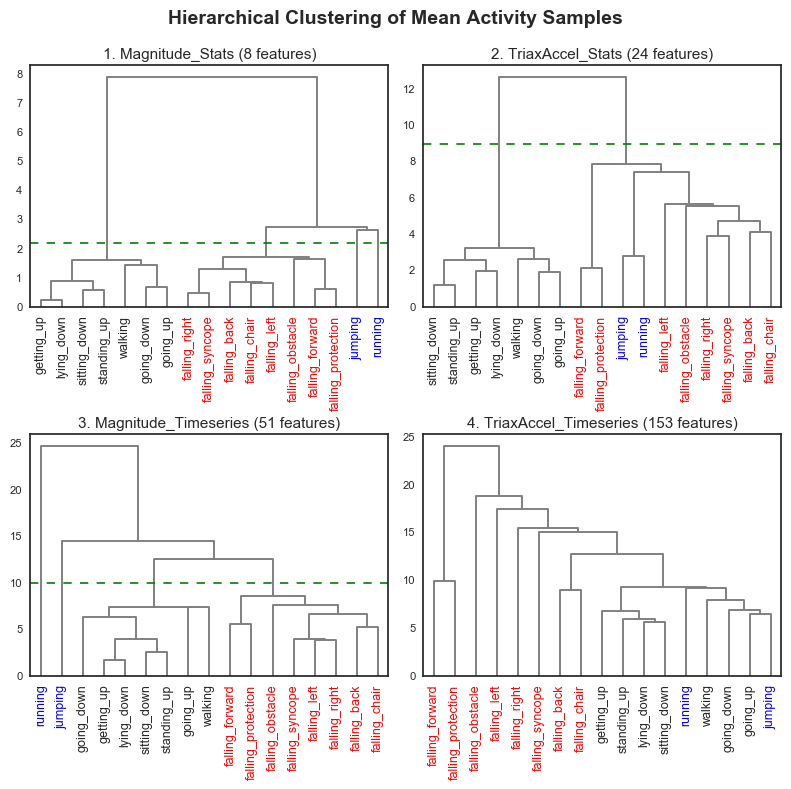

In [7]:
g,ax = plt.subplots(2,2, figsize = (8,8))
ax = ax.flatten()
cutoff_dist = [2.2,9,10,100]
count_plot = 0

#loop over all feature sets and build dendrograms
for data_id in [1,2,3,4]:
    
    #read and prepare data
    data_name = data_dict.get_value(data_id,'long_name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    df = df.join(test_dict[['activity','type']])
    df = df.drop('fall',axis = 1)
    
    # calulcate mean samples and build hierarchical clustering
    data_means = df.groupby(by = 'activity').mean()
    Z = hierarchy.linkage(data_means, 'single')
    
    # build dendogram  
    dn = hierarchy.dendrogram(Z,ax =ax[count_plot], labels = data_means.index, 
                            leaf_rotation = 90, leaf_font_size=9,link_color_func=lambda k: 'grey')    
    ax[count_plot].set_title('%d. %s' %(data_id, data_name), fontsize=11)
    ax[count_plot].set_ylabel = 'distance'
    
    # colour  code labels in red
    for i in ax[count_plot].get_xticklabels():
        activity_name = i.get_text() 
        if activity_name.startswith('falling'):
            i.set_color('red')
        elif activity_name in ('running','jumping'):
            i.set_color('blue')
    
    # draw horizontal lines for cluster cutoffs        
    ax[count_plot].axhline(cutoff_dist[count_plot],linewidth=1.2, linestyle='--', color = 'green')
    count_plot +=1
    
#decorate plot
plt.tight_layout()    
plt.subplots_adjust(top = 0.91)
plt.suptitle('Hierarchical Clustering of Mean Activity Samples', fontsize = 14, fontweight = 'bold');
plt.savefig('plots/dendogram.png')

-------------
## Principal components - separability of categories

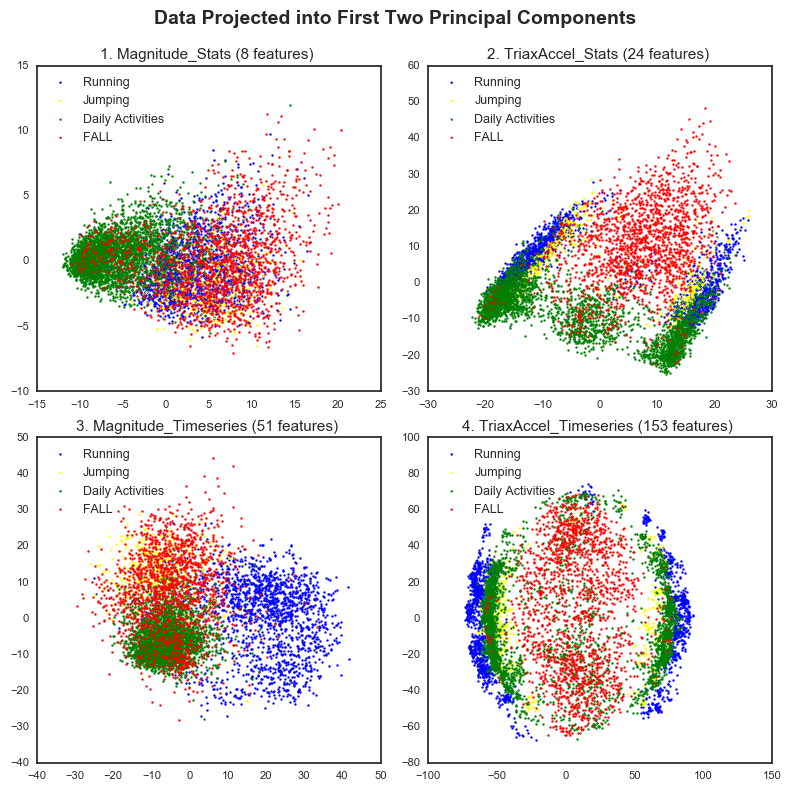

In [8]:
g,ax = plt.subplots(2,2, figsize = (8,8))
ax = ax.flatten()
count_plots = 0
for data_id in range(1,5):
    # get data
    data_name, data, target = get_data(data_dict,data_id = data_id)
    
    # perform PCA
    pca = PCA(n_components=2)
    data_pc = pd.DataFrame(pca.fit_transform(data), columns = ['PC1','PC2'])
    data_pc = data_pc.join(test_dict[['category']])
    
    # plot results by category
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='Running','PC1'], 
                            y = data_pc.loc[data_pc.category=='Running','PC2'], 
                            label = 'Running', c = 'blue', s = 2, edgecolors = 'face')
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='Jumping','PC1'], 
                            y = data_pc.loc[data_pc.category=='Jumping','PC2'], 
                            label ='Jumping', c = 'yellow', s = 2 , edgecolors = 'face')
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='ADL','PC1'], 
                            y = data_pc.loc[data_pc.category=='ADL','PC2'], 
                            label = 'Daily Activities', c = 'green', s = 2,edgecolors = 'face')
    ax[count_plots].scatter(x = data_pc.loc[data_pc.category=='FALL','PC1'], 
                            y = data_pc.loc[data_pc.category=='FALL','PC2'], 
                            label = 'FALL',c = 'red', s = 2 , edgecolors = 'face')
    
    ax[count_plots].set_title ( '%d. %s ' %(data_id, data_name), fontsize = 11)
    ax[count_plots].legend(loc='upper left', fontsize = 9)
    count_plots +=1
    
plt.tight_layout()    
plt.subplots_adjust(top = 0.91)
plt.suptitle('Data Projected into First Two Principal Components', fontsize = 14, fontweight = 'bold');
plt.savefig('plots/PCA_Scatter.png')    

----------------------------------
## Removing running and jumping - ROC curves for Logistic regression

In [9]:
# regularisation params for Logistic regressions
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'C': Cs, 'penalty':['l1','l2']}

Magnitude_Stats (8 features) All activities
Magnitude_Stats (8 features) Exc jump, run
TriaxAccel_Stats (24 features) All activities
TriaxAccel_Stats (24 features) Exc jump, run
Magnitude_Timeseries (51 features) All activities
Magnitude_Timeseries (51 features) Exc jump, run
TriaxAccel_Timeseries (153 features) All activities
TriaxAccel_Timeseries (153 features) Exc jump, run


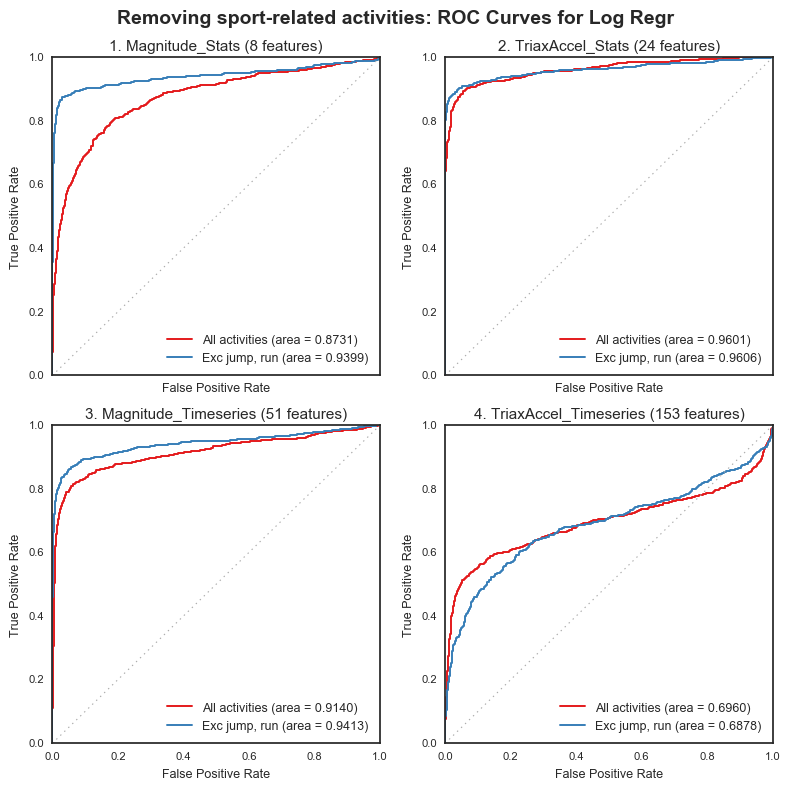

In [10]:
#prepare plot grid
sns.set_palette("Set1", 10)
g,ax = plt.subplots(2,2, figsize = (8,8), sharex=True)
ax = ax.flatten()
count_plots = 0

# go over all data sets and build ROC curves 
# (a) using all activities; (b) excluding jumping and running
res_store = pd.DataFrame()
for data_id in [1,2,3,4]:    
    # prepare data
    data_name, data_all, target_all = get_data(data_dict,data_id)
    data_exc, target_exc = remove_running_jumping (data_all, target_all, test_dict)
    labels  = ['All activities', 'Exc jump, run']
    
    # build models for each kind of data 
    for data, target, label in zip([data_all, data_exc],[target_all, target_exc], labels):
        print data_name, label
        
        #split into training and testing sets and normalise 
        X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
        # fit classifier and record results
        clf = GridSearchCV(LogisticRegression(), param_grid).fit(X_train, y_train)
        mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name="Log Regr",
                    data_name=data_name, data_kind = label, info=str(clf.best_params_))
        res_store = pd.concat([res_store, mm])
    
        # plot ROC curve
        fpr, tpr, _ = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        roc_auc = metrics.auc(fpr, tpr)
        ax[count_plots].plot(fpr, tpr, label= '%s (area = %0.4f)' %(label,roc_auc))
        
    #annotate plot
    ax[count_plots].plot([0, 1], [0, 1], color='darkgrey', linestyle=':', lw = 0.8)
    ax[count_plots].set_xlim([0.0, 1.0])
    ax[count_plots].set_ylim([0.0, 1.0])
    ax[count_plots].set_xlabel('False Positive Rate', fontsize=9)
    ax[count_plots].set_ylabel('True Positive Rate', fontsize=9)
    ax[count_plots].set_title('%d. %s' %(data_id,data_name), fontsize = 11)
    ax[count_plots].legend(loc="lower right", fontsize=9);         
    count_plots += 1    

# decorate plot
plt.tight_layout()    
plt.subplots_adjust(top = 0.92)
plt.suptitle('Removing sport-related activities: ROC Curves for Log Regr',
              fontsize = 14, fontweight = 'bold');
plt.savefig('plots/Roc_Curves_RemoveRunningJumping.png')

## Classification 

In [11]:
# prepare classifiers and parameter grids
clf_names = ['Logistic Regression','k-Nearest Neighbour','Random Forest','SVM']

classifiers = [LogisticRegression(), 
               neighbors.KNeighborsClassifier(),
               RandomForestClassifier(max_features='log2'),
               svm.SVC(kernel= 'rbf',probability=True)]

param_grids = [{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty':['l1','l2']}, # log regr
               {'n_neighbors': [3,5,7,9] }, # kNN 
               {'n_estimators': [50,70,100,200,400] }, # random forest 
               {'C': [0.01, 0.1, 1, 10, 100, 1000]}] # SVM                     

Magnitude_Stats (8 features)
Logistic Regression :  0:00:00.440204
k-Nearest Neighbour :  0:00:01.267066
Random Forest :  0:00:31.242141
SVM :  0:00:29.006432
TriaxAccel_Stats (24 features)
Logistic Regression :  0:00:00.726518
k-Nearest Neighbour :  0:00:06.123046
Random Forest :  0:00:29.251999
SVM :  0:00:12.752613
Magnitude_Timeseries (51 features)
Logistic Regression :  0:00:01.442293
k-Nearest Neighbour :  0:00:16.968200
Random Forest :  0:00:34.396412
SVM :  0:00:26.898400
TriaxAccel_Timeseries (153 features)
Logistic Regression :  0:00:23.475670
k-Nearest Neighbour :  0:00:41.996951
Random Forest :  0:00:39.945759
SVM :  0:01:08.699743


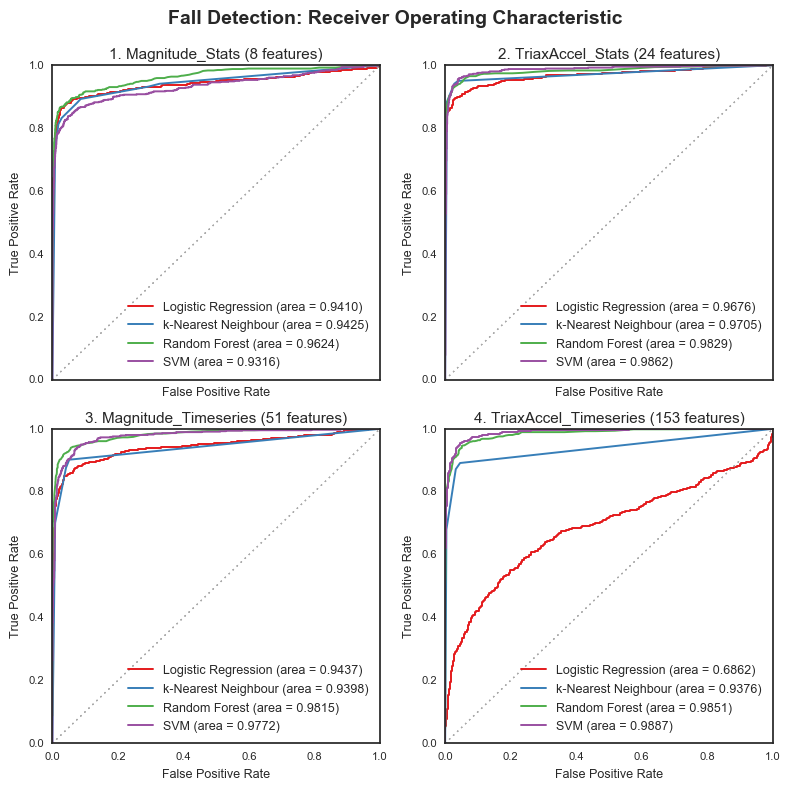

In [12]:
#prepare plot grid
sns.set_palette("Set1", 10)
g,ax = plt.subplots(2,2, figsize = (8,8), sharex=True)
ax = ax.flatten()
count_plots = 0

# go over all data sets and classify
res_store = pd.DataFrame()
for data_id in [1,2,3,4]:
    # get data and remove jumping and running samples
    data_name, data, target = get_data(data_dict,data_id)
    data, target = remove_running_jumping (data, target, test_dict)
    print data_name
       
    #split into training and testing sets and normalise 
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns, index = X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)
        
    # balance data by duplicating falls
    X_train = X_train.append(X_train[y_train== 1])
    y_train = y_train.append(y_train[y_train== 1])
    
    # loop over classifiers
    for classifier, clf_name, param_grid in zip(classifiers, clf_names, param_grids):
        # fit classifier
        timer_start = datetime.now()
        clf = GridSearchCV(classifier, param_grid).fit(X_train, y_train)
        
        # record results
        mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name=clf_name,
                    data_name=data_name, data_kind = 'balanced', info=str(clf.best_params_))
        res_store = pd.concat([res_store, mm])
        
        # plot ROC curve
        fpr, tpr, _ = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        roc_auc = metrics.auc(fpr, tpr)
        ax[count_plots].plot(fpr, tpr, label= '%s (area = %0.4f)' %(clf_name,roc_auc))
        ax[count_plots].plot([0, 1], [0, 1], color='darkgrey', linestyle=':', lw = 0.8)
        ax[count_plots].set_xlim([0.0, 1.0])
        ax[count_plots].set_ylim([0.0, 1.0])
        ax[count_plots].set_xlabel('False Positive Rate', fontsize=9)
        ax[count_plots].set_ylabel('True Positive Rate', fontsize=9)
        ax[count_plots].set_title('%d. %s' %(data_id,data_name), fontsize = 11)
        ax[count_plots].legend(loc="lower right", fontsize=9); 
        print clf_name, ": ", datetime.now() - timer_start
        
    count_plots += 1    

# decorate plot
plt.tight_layout()    
plt.subplots_adjust(top = 0.91)
plt.suptitle('Fall Detection: Receiver Operating Characteristic', fontsize = 14, fontweight = 'bold');
plt.savefig('plots/Roc_Curves_AllClassifiers.png')     

In [13]:
res_store.to_csv('out/model_metrics_AllClassifiers.csv')
res_store

,data_set,data_kind,classifier,test_accuracy,test_PoD,test_PFA,test_AUC,train_accuracy,train_PoD,train_PFA,train_AUC,info
0,Magnitude_Stats (8 features),balanced,Logistic Regression,0.914198,0.894260,0.075617,0.941011,0.906392,0.893925,0.080000,0.942585,"{'penalty': 'l1', 'C': 0.1}"
0,Magnitude_Stats (8 features),balanced,k-Nearest Neighbour,0.909602,0.880665,0.075617,0.942506,0.930045,0.914176,0.052632,0.984271,{'n_neighbors': 7}
0,Magnitude_Stats (8 features),balanced,Random Forest,0.931563,0.876133,0.040123,0.962417,1.000000,1.000000,0.000000,1.000000,{'n_estimators': 400}
0,Magnitude_Stats (8 features),balanced,SVM,0.908580,0.841390,0.057099,0.931603,0.975591,0.956606,0.003684,0.994533,{'C': 1000}
0,TriaxAccel_Stats (24 features),balanced,Logistic Regression,0.932074,0.907855,0.055556,0.967587,0.938098,0.923819,0.046316,0.975113,"{'penalty': 'l1', 'C': 1}"
0,TriaxAccel_Stats (24 features),balanced,k-Nearest Neighbour,0.961696,0.941088,0.027778,0.970452,0.992954,1.000000,0.014737,0.999488,{'n_neighbors': 3}
0,TriaxAccel_Stats (24 features),balanced,Random Forest,0.958631,0.919940,0.021605,0.982912,1.000000,1.000000,0.000000,1.000000,{'n_estimators': 70}
0,TriaxAccel_Stats (24 features),balanced,SVM,0.961185,0.935045,0.025463,0.986224,1.000000,1.000000,0.000000,1.000000,{'C': 1000}
0,Magnitude_Timeseries (51 features),balanced,Logistic Regression,0.911645,0.871601,0.067901,0.943719,0.904378,0.880424,0.069474,0.949954,"{'penalty': 'l1', 'C': 1}"
0,Magnitude_Timeseries (51 features),balanced,k-Nearest Neighbour,0.930541,0.876133,0.041667,0.939801,0.989431,1.000000,0.022105,0.997453,{'n_neighbors': 3}
